# Import Packages

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

# Steps

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera Calibration

In [25]:
# Create function to return image and object points for an image
def get_cal_points(image,nx,ny):
    
    # Debugplot flag
    debugplot = False
    
    # Initialize image and object points to empty
    objp = []
    imgp = []
    
    # Convert to grayscale
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(image_gray, (nx, ny), None)
    
    # If found, update image and object points
    if ret == True:
        objp = np.zeros((nx*ny,3),np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
        imgp = corners
        
        # Debugplot
        if debugplot:
            plt.figure()
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            plt.imshow(image)
    
    return ret,objp,imgp

# Initialize arrays to store all image and object points
objpoints = []
imgpoints = []

# Go through each file and obtain object and image points
files = os.listdir("camera_cal/")
nx = 9
ny = 6
for file in files:
    image = cv2.imread('camera_cal/' + file)
    ret,objp,imgp = get_cal_points(image,nx,ny)
    if ret:
        objpoints.append(objp)
        imgpoints.append(imgp)

# Obtain camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[1::-1], None, None)


## Apply distortion correction

Text(0.5, 1.0, 'undistorted')

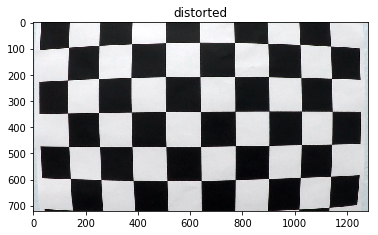

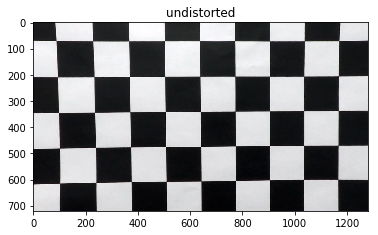

In [26]:
# Undistort an image as an example
file_num = 6
image = cv2.imread('camera_cal/' + files[file_num])
undist = cv2.undistort(image, mtx, dist, None,mtx)
plt.figure()
plt.imshow(image)
plt.title('distorted')
plt.figure()
plt.imshow(undist)
plt.title('undistorted')


## Create thresholded binary image

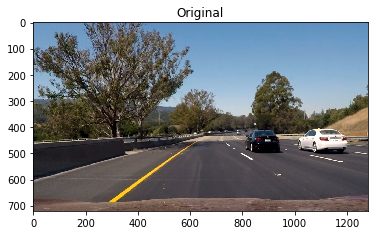

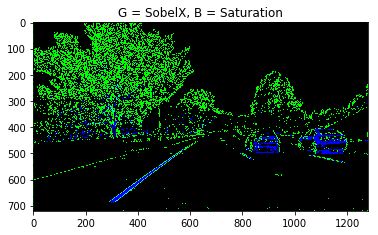

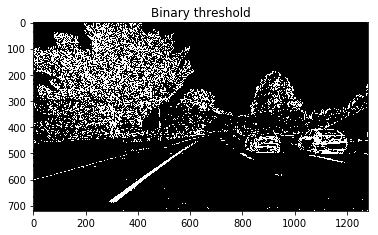

In [32]:
# Function to obtain binary threshold
def get_bin_thresh(image,sx_thresh=(20, 100),sat_thresh=(170, 255)):
    
    # Debugplot flag
    debugplot = True

    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold sobel x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    sat_binary = np.zeros_like(s_channel)
    sat_binary[(s_channel >= sat_thresh[0]) & (s_channel <= sat_thresh[1])] = 1
    
    # Create binary image
    bin_thresh = np.zeros_like(image)
    bin_thresh[(sx_binary > 0) | (sat_binary > 0)]=1
    
    
    # Debugplot
    if debugplot:
        plt.figure()
        plt.imshow(image)
        plt.title('Original')
        
        plt.figure()
        color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, sat_binary)) * 255
        plt.imshow(color_binary)
        plt.title('G = SobelX, B = Saturation')
        
        plt.figure()
        plt.imshow(bin_thresh * 255)
        plt.title('Binary threshold')
        
    return bin_thresh

# Obtain test image files
files = os.listdir("test_images/")
file_num = 0
image = cv2.imread('test_images/' + files[file_num])

# Convert to RGB
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image_bin = get_bin_thresh(image)*255

## Perspective transform

Text(0.5, 1.0, 'Warped binary')

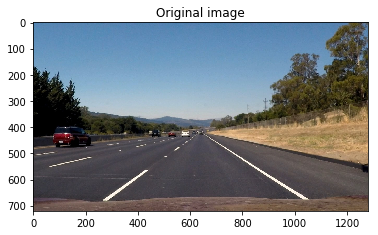

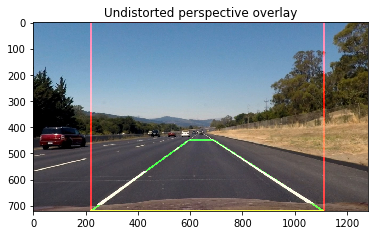

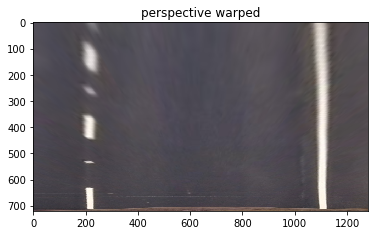

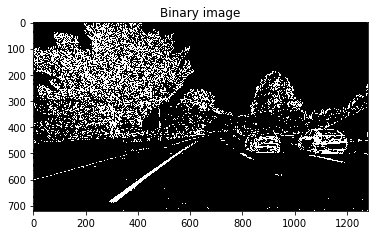

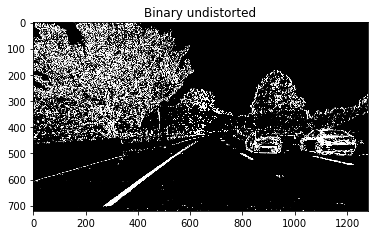

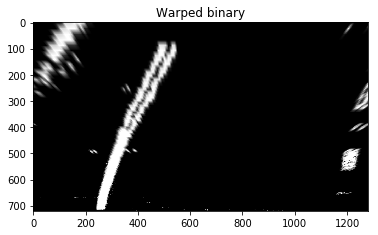

In [35]:
# Obtain test image
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

height = image.shape[0]
width = image.shape[1]

# Undistort the image
image_undist = cv2.undistort(image, mtx, dist, None,mtx)

# Pick perspective source points
src = np.array([[(220,height),(595,450),(690,450),(1110,height)]],dtype=np.int32)

# Create overalay of source points
overlay_src = np.zeros_like(image_undist)
cv2.polylines(overlay_src,src,True,(0,255,0),5)

# Pick perspective destination points
dst = np.array([[(src[0][0][0],height),(src[0][0][0],0),(src[0][3][0],0),(src[0][3][0],height)]],dtype=np.int32)

# Create mask of destination points
overlay_dst = np.zeros_like(image_undist)
cv2.polylines(overlay_dst,dst,True,(255,0,0),5)

# Display the source and destination masks on image
alpha = 0.8
beta = 1
gamma = 0
image_overlayed = cv2.addWeighted(overlay_src,alpha,image_undist,beta,gamma)
image_overlayed = cv2.addWeighted(overlay_dst,alpha,image_overlayed,beta,gamma)

# Get perspective transform
M = cv2.getPerspectiveTransform(np.float32(src),np.float32(dst))

# Get warped image
warped = cv2.warpPerspective(image_undist,M,image.shape[1::-1], flags=cv2.INTER_LINEAR)

# Display originial, undistorted and warped images
plt.figure()
plt.imshow(image)
plt.title('Original image')
plt.figure()
plt.imshow(image_overlayed)
plt.title('Undistorted perspective overlay')
plt.figure()
plt.imshow(warped)
plt.title('perspective warped')

# Perform correction for binary image

# Undistort the image
image = image_bin
image_undist = cv2.undistort(image, mtx, dist, None,mtx)
warped = cv2.warpPerspective(image_undist,M,image.shape[1::-1], flags=cv2.INTER_LINEAR)
plt.figure()
plt.imshow(image)
plt.title('Binary image')
plt.figure()
plt.imshow(image_undist)
plt.title('Binary undistorted')
plt.figure()
plt.imshow(warped)
plt.title('Warped binary')
